In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import networkx as nx
from scipy import stats

from node2vec import Node2Vec
from sklearn.metrics.pairwise import cosine_similarity
from urllib.parse import unquote

c:\Users\Anasse\miniconda3\envs\ada\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH_2007 = os.path.join('data', '2007')
PATH_2024 = os.path.join('data', '2024')

In [3]:
articles = pd.read_csv(os.path.join(PATH_2007, 'articles.tsv'), sep='\t', comment='#', names=['article'])
links2007 = pd.read_csv(os.path.join(PATH_2007, 'links.tsv'), sep='\t', comment='#', names=['linkSource', 'linkTarget'])
links2024 = pd.read_csv(os.path.join(PATH_2024, 'links2024.csv'), comment='#')
links2024 = links2024.drop_duplicates().reset_index(drop=True)

# url string decoding
links2007['linkSource'] = links2007['linkSource'].apply(unquote)
links2007['linkTarget'] = links2007['linkTarget'].apply(unquote)
articles['article'] = articles['article'].apply(unquote)

links2024['linkSource'] = links2024['linkSource'].apply(unquote)
links2024['linkTarget'] = links2024['linkTarget'].apply(unquote)

## Node2vec to compute similarity

In [59]:
# create a graph with links dataframe
G_2007 = nx.DiGraph()
G_2007.add_nodes_from(articles['article'])

for i, row in links2007.iterrows():
    if row['linkSource'] in G_2007.nodes and row['linkTarget'] in G_2007.nodes:
        G_2007.add_edge(row['linkSource'], row['linkTarget'])    

In [60]:
G_2024 = nx.DiGraph()
G_2024.add_nodes_from(articles['article'])

for i, row in links2024.iterrows():
    if row['linkSource'] in G_2024.nodes and row['linkTarget'] in G_2024.nodes:
        G_2024.add_edge(row['linkSource'], row['linkTarget'])

In [ ]:
node2vec_2007 = Node2Vec(G_2007, dimensions=64, walk_length=30, num_walks=200, workers=1)

# Generate embeddings
model_2007 = node2vec_2007.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/4604 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [04:24<00:00,  1.32s/it]


In [7]:
node2vec_2024 = Node2Vec(G_2024, dimensions=64, walk_length=30, num_walks=200, workers=1)
model_2024 = node2vec_2024.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/4604 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [06:20<00:00,  1.90s/it]


In [ ]:
model_2007.save('node2vec_2007.model')
model_2024.save('node2vec_2024.model')

In [ ]:
from gensim.models import Word2Vec

# Load the model
model_2007 = Word2Vec.load('node2vec_2007.model')
model_2024 = Word2Vec.load('node2vec_2024.model')

In [61]:
embeddings_2007 = {node: model_2007.wv[node] for node in G_2007.nodes()}
embeddings_2024 = {node: model_2024.wv[node] for node in G_2024.nodes()}

In [ ]:
embedding_array_2007 = np.array(list(embeddings_2007.values()))
embedding_array_2024 = np.array(list(embeddings_2024.values()))

cosine_similarities_2007 = cosine_similarity(embedding_array_2007)
cosine_similarities_2024 = cosine_similarity(embedding_array_2024)

In [23]:
list(embeddings_2007.keys())[1000], list(embeddings_2024.keys())[1000]

('Community', 'Community')

In [24]:
cosine_similarities_2007[1000, 500], cosine_similarities_2024[1000, 500]

(0.19127513, 0.1332477)

Check similarity of all output link in each article

In [62]:
to_remove = [i for i in links2024['linkSource'].unique() if i not in articles['article'].unique()]
to_remove

['Track_and_field',
 'Bionicle:_Mask_of_Light',
 'Direct_debit',
 'News_Hounds',
 'Star_Wars_(film)',
 'X-Men:_The_Last_Stand']

In [63]:
to_remove = [i for i in links2024['linkTarget'].unique() if i not in articles['article'].unique()]
to_remove += [i for i in links2024['linkSource'].unique() if i not in articles['article'].unique()]
links2024 = links2024[~links2024['linkTarget'].isin(to_remove)]
links2024 = links2024[~links2024['linkSource'].isin(to_remove)]

In [90]:
links2024['similarity'] = links2024.apply(lambda x: cosine_similarities_2024[list(embeddings_2024.keys()).index(x['linkSource']), list(embeddings_2024.keys()).index(x['linkTarget'])], axis=1)
links2007['similarity'] = links2007.apply(lambda x: cosine_similarities_2007[list(embeddings_2007.keys()).index(x['linkSource']), list(embeddings_2007.keys()).index(x['linkTarget'])], axis=1)

In [91]:
similarity_2007 = links2007.groupby('linkSource')['similarity'].mean().reset_index()
similarity_2024 = links2024.groupby('linkSource')['similarity'].mean().reset_index()

In [67]:
unique_article2007 = similarity_2007['linkSource'].unique()
unique_article2024 = similarity_2024['linkSource'].unique()

for i, row in articles.iterrows():
    if row['article'] not in unique_article2007:
        # add the article to the similarity dataframe
        similarity_2007 = pd.concat([similarity_2007, pd.DataFrame({'linkSource': [row['article']], 'similarity': [0]})], ignore_index=True)
    
    if row['article'] not in unique_article2024:
        # add the article to the similarity dataframe
        similarity_2024 = pd.concat([similarity_2024, pd.DataFrame({'linkSource': [row['article']], 'similarity': [0]})], ignore_index=True)

In [72]:
# merge similarity the 2 dataframes with articles
similarities = pd.merge(similarity_2007, similarity_2024, on='linkSource', how='outer', suffixes=('_2007', '_2024'))

# rename column linkSource to article
similarities = similarities.rename(columns={'linkSource': 'article'})
similarities

,article,similarity_2007,similarity_2024
0,10th_century,0.433974,0.496930
1,11th_century,0.568461,0.382620
2,12th_century,0.563734,0.489039
3,13th_century,0.441702,0.568082
4,14th_century,0.478573,0.439909
...,...,...,...
4599,Suikinkutsu,0.000000,0.000000
4600,Underground_(stories),0.000000,0.000000
4601,Vacutainer,0.000000,0.596388
4602,Wikipedia_Text_of_the_GNU_Free_Documentation_L...,0.000000,0.000000


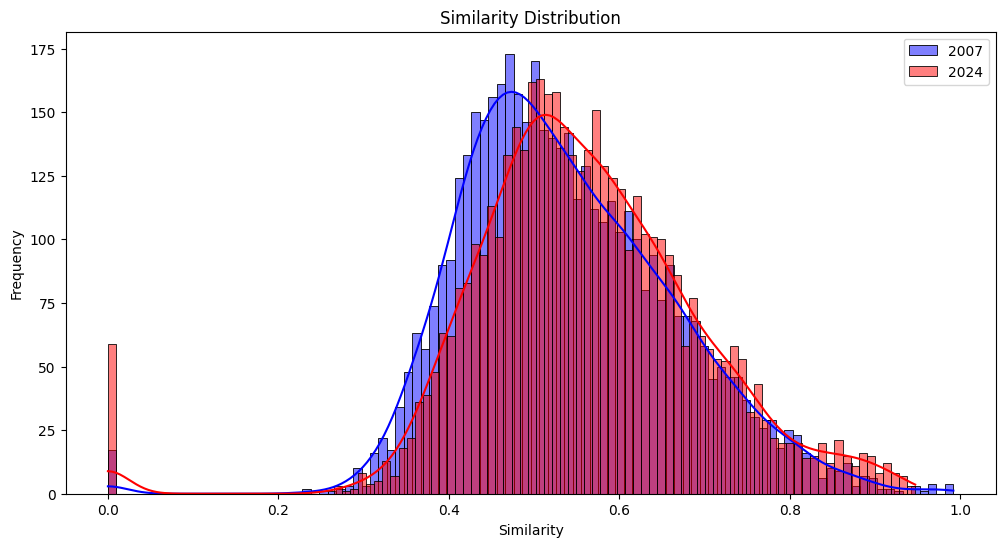

In [78]:
# plot the similarity distribution
plt.figure(figsize=(12, 6))
sns.histplot(similarities['similarity_2007'], kde=True, bins=100, color='blue', label='2007')
sns.histplot(similarities['similarity_2024'], kde=True, bins=100, color='red', label='2024')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Similarity Distribution')
plt.legend()
plt.show()

## Word embedding of article content to compute similarity

### Get article content from wikipedia (only summary)

#### 2007

In [4]:
def extract_first_paragraph(text):
    # Split the text by new lines
    lines = text.split('\n')

    # ignore the 5 first lines
    lines = lines[5:]

    # while a line don't begin by "   ", remove it
    while lines[0][:3] != "   ":
        lines = lines[1:]

    # List to accumulate lines of the first paragraph
    paragraph_lines = []
    paragraph_started = False

    for l in lines:
        if l[:3] == "   " or not l:
            paragraph_started = True
            paragraph_lines.append(l)
        elif paragraph_started:
            break

    # Join the lines to form the paragraph
    paragraph = '\n'.join(paragraph_lines)

    # return paragraph
    return paragraph

In [42]:
ARTICLE_TXT_PATH = os.path.join('data', '2007', 'plaintext_articles')

summaries2007 = {'article' : [], 'content' : []}

for filename in tqdm(os.listdir(ARTICLE_TXT_PATH)):
    with open(os.path.join(ARTICLE_TXT_PATH, filename), 'r', encoding='utf8') as f:
        text = f.read() 

    paragraph = extract_first_paragraph(text)
    summaries2007['article'].append(unquote(filename[:-4]))
    summaries2007['content'].append(paragraph.strip())

summaries2007 = pd.DataFrame(summaries2007)
summaries2007.to_csv(os.path.join('data', '2007', 'summaries2007.csv'), index=False, encoding='utf8')

  0%|          | 0/4604 [00:00<?, ?it/s]

100%|██████████| 4604/4604 [00:46<00:00, 99.58it/s] 


In [43]:
summaries2007

,article,content
0,Áedán_mac_Gabráin,Satellite image of northern Britain and Irelan...
1,Åland,Landskapet Åland\n Ahvenanmaan maakunta\n ...
2,Édouard_Manet,Articles with similar titles include Claude Mo...
3,Éire,This is a featured article. Click here for mor...
4,Óengus_I_of_the_Picts,Óengus son of Fergus\n King of the Picts\n ...
...,...,...
4599,Zirconium,40 yttrium ← zirconium → niobium\...
4600,Zoroaster,Part of a series on\n\n Zoroastrianism\n P...
4601,Zuid-Gelders,This article is a part of\n\n the Dutch dial...
4602,Zulu,"Zulus\n\n Zulu Warriors, late 19th century (..."


### 2024

In [20]:
# import wikipediaapi # need python 3.9 or higher to work
# from time import sleep

# wiki_wiki = wikipediaapi.Wikipedia('ada (anasse.elboudiri@epfl.ch)', 'en')

# summaries2024 = {'article' : [], 'content' : []}

# for article in articles['article']:
#     page = wiki_wiki.page(article)
#     if page.exists():
#         summaries2024['article'].append(article)
#         summaries2024['content'].append(page.summary)
#     sleep(0.1)

# # article names that are different in 2007 and 2024
# old_names = ["Athletics_%28track_and_field%29",
#              "Bionicle__Mask_of_Light",
#              "Directdebit",
#              "Newshounds",
#              "Star_Wars_Episode_IV__A_New_Hope",
#              "Wikipedia_Text_of_the_GNU_Free_Documentation_License",
#              "X-Men__The_Last_Stand"]

# new_names = ["Track_and_field",
#             "Bionicle:_Mask_of_Light",
#             "Direct_debit",
#             "News_Hounds",
#             "Star_Wars_(film)",
#             "Wikipedia:Text_of_the_GNU_Free_Documentation_License",
#             "X-Men:_The_Last_Stand"]

# for old, new in zip(old_names, new_names):
#     page = wiki_wiki.page(new)
#     if page.exists():
#         summaries2024['article'].append(unquote(old))
#         summaries2024['content'].append(page.summary)
    
# summaries2024 = pd.DataFrame(summaries2024)
# summaries2024.to_csv(os.path.join('data', '2024', 'summaries2024.csv'), index=False, encoding='utf-8')

summaries2024 = pd.read_csv(os.path.join('data', '2024', 'summaries2024.csv'), encoding='utf-8')

In [21]:
summaries2024

,article,content
0,Áedán_mac_Gabráin,Áedán mac Gabráin (Old Irish pronunciation: [ˈ...
1,Åland,Åland (Swedish: [ˈǒːland] ; Finnish: Ahvenanma...
2,Édouard_Manet,"Édouard Manet (UK: , US: ; French: [edwaʁ manɛ..."
3,Éire,Éire (Irish: [ˈeːɾʲə] ) is the Irish Gaelic na...
4,Óengus_I_of_the_Picts,Óengus son of Fergus (Pictish: *Onuist map Vur...
...,...,...
4595,Directdebit,A direct debit or direct withdrawal is a finan...
4596,Newshounds,News Hounds is a 1947 American comedy film dir...
4597,Star_Wars_Episode_IV__A_New_Hope,Star Wars (later retitled Star Wars: Episode I...
4598,Wikipedia_Text_of_the_GNU_Free_Documentation_L...,"Version 1.3, 3 November 2008\nCopyright (C) 20..."


#### text preprocessing

In [9]:
import gensim
import string
import re
from nltk import download
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter

In [11]:
def preprocess_text(text):
    stopwords = gensim.parsing.preprocessing.STOPWORDS

    # remove stopwords
    text = ' '.join([word for word in text.split(" ") if word.lower() not in stopwords])

    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # remove digits
    # text = text.translate(str.maketrans('', '', string.digits))
    text = re.sub(r'\d+', '', text)

    # tokenize the text
    text = word_tokenize(text)

    # add bigrams
    bigrams = ['-'.join(bg) for bg in ngrams(text, 2)]
    text += bigrams
    return text

In [12]:
# apply preprocessing 
summaries2007['text'] = summaries2007['content'].apply(preprocess_text)
summaries2024['text'] = summaries2024['content'].apply(preprocess_text)

In [13]:
def remove_frequent_word(df):
    word_freq = Counter([word for text in df['text'] for word in text])
    frequent_words = set([word for word, freq in word_freq.items() if freq > 1000])
    infrequent_words = set([word for word, freq in word_freq.items() if freq < 5])
    df['text'] = df['text'].apply(lambda x: [word for word in x if word not in frequent_words and word not in infrequent_words])

In [14]:
remove_frequent_word(summaries2007)
remove_frequent_word(summaries2024)

#### SBERT

In [10]:
from sentence_transformers import SentenceTransformer, util

In [11]:
# Load the SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
embeddings_2007_summary = model.encode(summaries2007['content'])
embeddings_2024_summary = model.encode(summaries2024['content'])

In [ ]:
embedding_array_2007_summary = np.array(list(embeddings_2007_summary.values()))
embedding_array_2024_summary = np.array(list(embeddings_2024_summary.values()))

cosine_similarities_2007_summary = cosine_similarity(embedding_array_2007_summary)
cosine_similarities_2024_summary = cosine_similarity(embedding_array_2024_summary)

In [26]:
links2024['similarity'] = links2024.apply(lambda x: cosine_similarities_2024_summary[list(embeddings_2024_summary.keys()).index(x['linkSource']), 
                                                                                     list(embeddings_2024_summary.keys()).index(x['linkTarget'])], axis=1)

In [67]:
links2007['similarity'] = links2007.apply(lambda x: cosine_similarities_2007_summary[list(embeddings_2007_summary.keys()).index(x['linkSource']),
                                                                                     list(embeddings_2007_summary.keys()).index(x['linkTarget'])], axis=1)

In [78]:
links2024[21000:23000]

,linkSource,linkTarget,similarity
21000,Bahrain,Royal_Navy,0.094420
21001,Bahrain,European_Parliament,0.037769
21002,Bahrain,The_Wall_Street_Journal,-0.001209
21003,Bahrain,Arable_land,0.327052
21004,Bahrain,Agriculture,0.225983
...,...,...,...
22995,Baroque,Piano,0.095655
22996,Baroque,Johann_Sebastian_Bach,0.289774
22997,Baroque,Johann_Pachelbel,0.336096
22998,Baroque,Dido_and_Aeneas,0.249529


In [68]:
similarity_2007 = links2007.groupby('linkSource')['similarity'].mean().reset_index()
similarity_2024 = links2024.groupby('linkSource')['similarity'].mean().reset_index()

In [69]:
unique_article2007 = similarity_2007['linkSource'].unique()
unique_article2024 = similarity_2024['linkSource'].unique()

for i, row in articles.iterrows():
    if row['article'] not in unique_article2007:
        # add the article to the similarity dataframe
        similarity_2007 = pd.concat([similarity_2007, pd.DataFrame({'linkSource': [row['article']], 'similarity': [0]})], ignore_index=True)
    
    if row['article'] not in unique_article2024:
        # add the article to the similarity dataframe
        similarity_2024 = pd.concat([similarity_2024, pd.DataFrame({'linkSource': [row['article']], 'similarity': [0]})], ignore_index=True)

In [70]:
# merge similarity the 2 dataframes with articles
similarities = pd.merge(similarity_2007, similarity_2024, on='linkSource', how='outer', suffixes=('_2007', '_2024'))

# rename column linkSource to article
similarities = similarities.rename(columns={'linkSource': 'article'})
similarities

,article,similarity_2007,similarity_2024
0,10th_century,0.143167,0.320966
1,11th_century,0.355446,0.234856
2,12th_century,0.357947,0.292849
3,13th_century,0.183783,0.385664
4,14th_century,0.175292,0.280846
...,...,...,...
4599,Åland,0.279728,0.287250
4600,Édouard_Manet,0.182135,0.294430
4601,Éire,0.343146,0.334726
4602,Óengus_I_of_the_Picts,0.213862,0.349193


In [72]:
similarities.describe()

,similarity_2007,similarity_2024
count,4604.000000,4604.000000
mean,0.225035,0.236082
std,0.104558,0.091296
min,-0.133736,-0.095537
25%,0.153441,0.178067
50%,0.215187,0.235620
75%,0.284780,0.293108
max,0.948843,0.628260


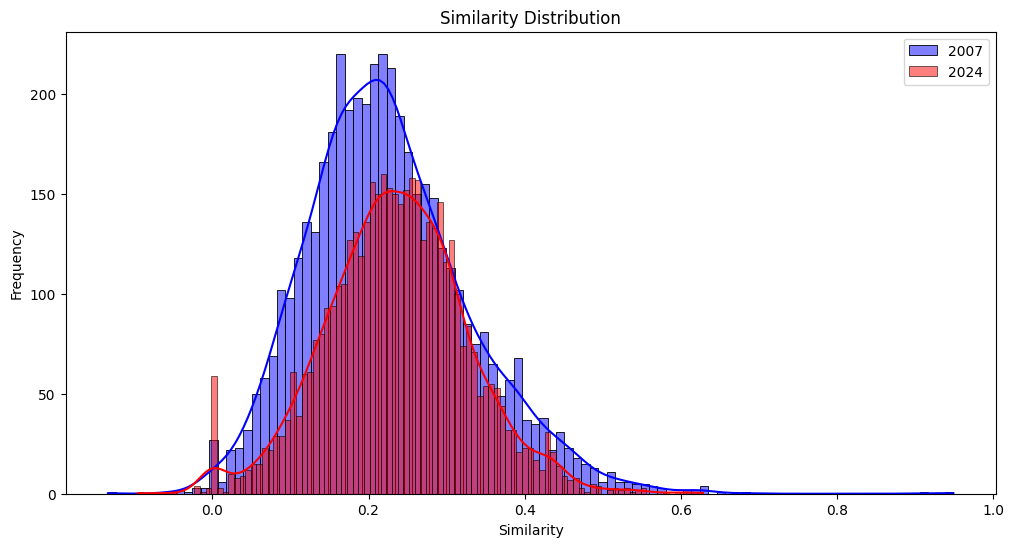

In [71]:
# plot the similarity distribution
plt.figure(figsize=(12, 6))
sns.histplot(similarities['similarity_2007'], kde=True, bins=100, color='blue', label='2007')
sns.histplot(similarities['similarity_2024'], kde=True, bins=100, color='red', label='2024')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Similarity Distribution')
plt.legend()
plt.show()